In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import glob
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.multiclass import OneVsOneClassifier
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

In [2]:
all_files = glob.glob('**/*.csv', recursive=True)

For load files, I found a small error in file 'cycling\dataset14.csv', 'cycling\dataset9.csv',
by correct it manually, I can load data smoothly.

1.(a)Loading files

In [3]:
all_dfs = []
for file in all_files:
    all_dfs.append(pd.read_csv(file,skiprows=4))

print(len(all_dfs))

88


1.(b) Divide files into test data and train data.

In [4]:
test_series = [0,1,7,8,13,20,21,28,35,36,43,50,51,58,65,66,73,80,81]
for i in test_series:
    print(all_files[i])

bending1\dataset1.csv
bending1\dataset2.csv
bending2\dataset1.csv
bending2\dataset2.csv
cycling\dataset1.csv
cycling\dataset2.csv
cycling\dataset3.csv
lying\dataset1.csv
lying\dataset2.csv
lying\dataset3.csv
sitting\dataset1.csv
sitting\dataset2.csv
sitting\dataset3.csv
standing\dataset1.csv
standing\dataset2.csv
standing\dataset3.csv
walking\dataset1.csv
walking\dataset2.csv
walking\dataset3.csv


In [5]:
test_dfs = []
train_dfs = []

for i in range(0,88):
    if i in test_series:
        test_dfs.append(all_dfs[i])
    else:
        train_dfs.append(all_dfs[i])
        
print(len(test_dfs))
print(len(train_dfs))

19
69


In [6]:
all_dfs[0].describe()

,# Columns: time,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23
count,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000
mean,59875.000000,40.624792,0.358604,19.040937,0.832542,34.311292,0.570583
std,34677.081769,1.476967,0.322605,4.462952,0.965659,2.188449,0.582915
min,0.000000,37.250000,0.000000,4.000000,0.000000,27.250000,0.000000
25%,29937.500000,39.250000,0.000000,16.000000,0.000000,33.000000,0.000000
50%,59875.000000,40.500000,0.430000,19.250000,0.500000,35.000000,0.430000
75%,89812.500000,42.000000,0.500000,23.250000,1.120000,36.000000,1.300000
max,119750.000000,45.000000,1.300000,29.500000,7.230000,38.250000,1.920000


1.(c)Feature Extraction

i. Research

By research on Internet, in paper[1], researchers used 
1.Mean Absolute Value (MAV) 2.Root Mean Square (RMS)  3.Mean  4.Variance (VAR) 
5.Standard Deviation (STD) 6.Simple Sign Integral (SSI) 
etc.

[1]Analysis of Statistical Time-Domain Features Effectiveness in Identification of Bearing Faults From Vibration Signal
IEEE SENSORS JOURNAL, VOL. 17, NO. 17, SEPTEMBER 1, 2017
B. R. Nayana and P. Geethanjali, Member, IEEE


ii. Extract the time-domain features

In [7]:
features = pd.DataFrame(columns=['min1','max1','mean1','median1','std1','1stquart1','3rdquart1',
                                 'min2','max2','mean2','median2','std2','1stquart2','3rdquart2',
                                 'min3','max3','mean3','median3','std3','1stquart3','3rdquart3',
                                 'min4','max4','mean4','median4','std4','1stquart4','3rdquart4',
                                 'min5','max5','mean5','median5','std5','1stquart5','3rdquart5',
                                 'min6','max6','mean6','median6','std6','1stquart6','3rdquart6'])
for i in range(0,len(all_dfs)):
    df = all_dfs[i]
    dict = {}
    for j in range(1,7):
        dict['min'+str(j)] = df[df.columns[j]].min(axis = 0)
        dict['max'+str(j)] = df[df.columns[j]].max(axis = 0)
        dict['mean'+str(j)] = df[df.columns[j]].mean(axis = 0)
        dict['median'+str(j)] = df[df.columns[j]].median(axis = 0)
        dict['std'+str(j)] = df[df.columns[j]].std(axis = 0)
        dict['1stquart'+str(j)] = df[df.columns[j]].quantile(0.25)
        dict['3rdquart'+str(j)] = df[df.columns[j]].quantile(0.75)
        
    features = features.append(pd.DataFrame(dict,index=[i + 1]))

In [8]:
features.shape

(88, 42)

iii. 

Use your judgement to select the three most important time-domain features.


In [9]:
features.iloc[:,0:6].describe()

,1stquart1,1stquart2,1stquart3,1stquart4,1stquart5,1stquart6
count,88.00000,88.000000,88.000000,88.000000,88.000000,88.000000
mean,37.01983,0.745398,12.110682,0.719034,13.826761,0.902017
std,6.15359,0.946386,4.220658,0.843620,6.096465,0.758584
min,23.18750,0.000000,2.500000,0.000000,1.000000,0.000000
25%,31.62750,0.000000,10.250000,0.000000,11.295000,0.430000
50%,39.20000,0.430000,13.250000,0.430000,14.000000,0.470000
75%,42.00000,1.300000,14.250000,1.705625,15.500000,1.670000
max,48.00000,2.870000,20.500000,2.170000,35.362500,2.240000


In [10]:
features.iloc[:,6:12].describe()

,3rdquart1,3rdquart2,3rdquart3,3rdquart4,3rdquart5,3rdquart6
count,88.000000,88.000000,88.000000,88.000000,88.00000,88.000000
mean,41.197216,1.976080,16.733722,1.998920,18.52821,2.142614
std,5.138925,2.125266,4.171628,1.552504,5.53172,1.523599
min,26.500000,0.000000,6.000000,0.470000,5.54250,0.500000
25%,38.250000,0.500000,15.000000,0.830000,16.64250,1.000000
50%,40.250000,0.500000,17.585000,1.120000,18.28125,1.220000
75%,45.000000,3.766250,19.000000,4.007500,20.75000,4.043125
max,54.000000,6.105000,24.372500,4.440000,36.50000,4.617500


In [11]:
features.iloc[:,12:18].describe()

,max1,max2,max3,max4,max5,max6
count,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000
mean,45.473068,6.290114,22.810909,6.761250,24.320114,6.461932
std,4.394362,5.062729,4.875137,2.183625,5.741238,2.518921
min,30.000000,0.430000,11.330000,2.490000,12.000000,1.790000
25%,44.585000,1.767500,21.000000,5.165000,21.000000,4.500000
50%,45.750000,4.500000,23.500000,6.070000,23.500000,6.310000
75%,47.750000,10.930000,25.580000,9.000000,25.500000,8.765000
max,56.250000,17.240000,35.000000,11.420000,40.330000,13.610000


In [12]:
features.iloc[:,18:24].describe()

,mean1,mean2,mean3,mean4,mean5,mean6
count,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000
mean,38.917357,1.459119,14.278229,1.502218,16.035170,1.620686
std,5.335718,1.574164,4.008380,1.166114,5.675593,1.154812
min,24.562958,0.007167,4.382208,0.332063,4.303979,0.383292
25%,34.845755,0.366630,12.760526,0.614672,13.390958,0.730656
50%,39.433792,0.489365,15.299646,0.837208,15.993198,0.930188
75%,43.013250,2.731505,16.531083,2.988917,17.376687,3.005229
max,48.004167,4.576562,22.183625,3.365375,35.588458,3.530500


In [13]:
features.iloc[:,24:30].describe()

,median1,median2,median3,median4,median5,median6
count,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000
mean,38.856705,1.288068,14.613352,1.313352,16.239602,1.445511
std,5.440054,1.412244,4.036396,1.145586,5.813782,1.086474
min,24.250000,0.000000,4.500000,0.000000,2.250000,0.430000
25%,35.447500,0.430000,12.740000,0.470000,13.447500,0.500000
50%,39.415000,0.500000,15.330000,0.500000,16.125000,0.830000
75%,43.250000,2.185000,16.690000,2.860000,17.812500,2.615000
max,48.000000,4.260000,23.000000,3.200000,36.000000,3.340000


In [14]:
features.iloc[:,30:36].describe()

,min1,min2,min3,min4,min5,min6
count,88.000000,88.0,88.000000,88.0,88.000000,88.000000
mean,29.036705,0.0,3.101477,0.0,4.676364,0.004886
std,9.569975,0.0,2.956462,0.0,6.124001,0.045838
min,0.000000,0.0,0.000000,0.0,0.000000,0.000000
25%,21.875000,0.0,0.000000,0.0,0.000000,0.000000
50%,28.625000,0.0,2.250000,0.0,2.500000,0.000000
75%,36.270000,0.0,6.000000,0.0,6.812500,0.000000
max,48.000000,0.0,8.500000,0.0,29.000000,0.430000


In [15]:
features.iloc[:,36:42].describe()

,std1,std2,std3,std4,std5,std6
count,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000
mean,2.988893,0.987459,3.577925,1.067130,3.537752,1.048533
std,1.772153,0.884105,0.946710,0.458242,1.024898,0.517617
min,0.032038,0.055106,1.745801,0.409145,1.745970,0.388372
25%,1.468289,0.320845,2.946473,0.716983,2.942275,0.613688
50%,3.212700,0.455526,3.457400,0.903342,3.265060,0.838716
75%,4.552490,1.900389,3.987098,1.600137,4.074511,1.642064
max,7.684146,2.625516,7.638935,1.861730,7.853427,1.963685


By these 7 tables of different features,
I choose to use max, mean and std.

(d) Binary Classification Using Logistic Regression

i. Depict scatter plots of bending and other data.

In [16]:
bending_dfs = train_dfs[0:9]
other_dfs = train_dfs[9:]

In [17]:
bending_dfs[0].head()

,# Columns: time,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23
0,0,42.00,0.71,21.25,0.43,30.00,0.00
1,250,41.50,0.50,20.25,1.48,31.25,1.09
2,500,41.50,0.50,14.25,1.92,33.00,0.00
3,750,40.75,0.83,15.75,0.43,33.00,0.00
4,1000,40.00,0.71,20.00,2.74,32.75,0.43


In [18]:
df_bending = bending_dfs[0]
df_other = other_dfs[0]
for i in range(1,len(bending_dfs)):
    df_bending = pd.concat([df_bending,bending_dfs[i]])
    
for j in range(1,len(other_dfs)):
    df_other = pd.concat([df_other,other_dfs[j]])

In [19]:
df_bending.shape

(4320, 7)

In [20]:
def feature_select(dfs):
    features_selected = pd.DataFrame(columns=['max1','mean1','std1','max2','mean2','std2',
        'max6','mean6','std6'])
    for i in range(0,len(dfs)):
        df = dfs[i]
        dict = {}
        for j in [1,2,6]:
            dict['max'+str(j)] = df[df.columns[j]].max(axis = 0)
            dict['mean'+str(j)] = df[df.columns[j]].mean(axis = 0)
            dict['std'+str(j)] = df[df.columns[j]].std(axis = 0)
        features_selected = features_selected.append(pd.DataFrame(dict,index=[i + 1]))
    return features_selected

In [21]:
bending_training_features = feature_select(bending_dfs)
other_training_features = feature_select(other_dfs)

In [22]:
bending_training_features

,max1,max2,max6,mean1,mean2,mean6,std1,std2,std6
1,47.40,1.70,1.79,43.954500,0.426250,0.493292,1.558835,0.338690,0.513506
2,47.75,3.00,2.18,42.179813,0.696042,0.613521,3.670666,0.630860,0.524317
3,45.75,2.83,1.79,41.678063,0.535979,0.383292,2.243490,0.405469,0.389164
4,48.00,1.58,5.26,43.454958,0.378083,0.679646,1.386098,0.315566,0.622534
5,48.00,1.50,2.96,43.969125,0.413125,0.555313,1.618364,0.263111,0.487826
6,50.00,9.90,13.61,32.586208,0.516125,1.162042,6.238143,0.789957,1.332980
7,33.00,1.00,6.40,29.881938,0.256438,0.701625,1.153837,0.275833,0.481103
8,45.50,6.40,6.73,30.938104,0.467167,1.107354,7.684146,0.734444,1.080842
9,47.50,6.38,4.92,31.058250,0.405458,1.098104,4.829794,0.566668,0.831480


In [23]:
print(bending_training_features.shape)
print(other_training_features.shape)

(9, 9)
(60, 9)


In [24]:
bend_action = []
other_action = []
for i in range(0,bending_training_features.shape[0]+1):
    bend_action.append(1)
for i in range(0,other_training_features.shape[0]+1):
    other_action.append(0)

#set bending action as 1, other action as 0
    
    
bending_training_features['action'] = pd.Series(bend_action)
other_training_features['action'] = pd.Series(other_action)

df_training_bending_and_other = pd.concat([bending_training_features,other_training_features])

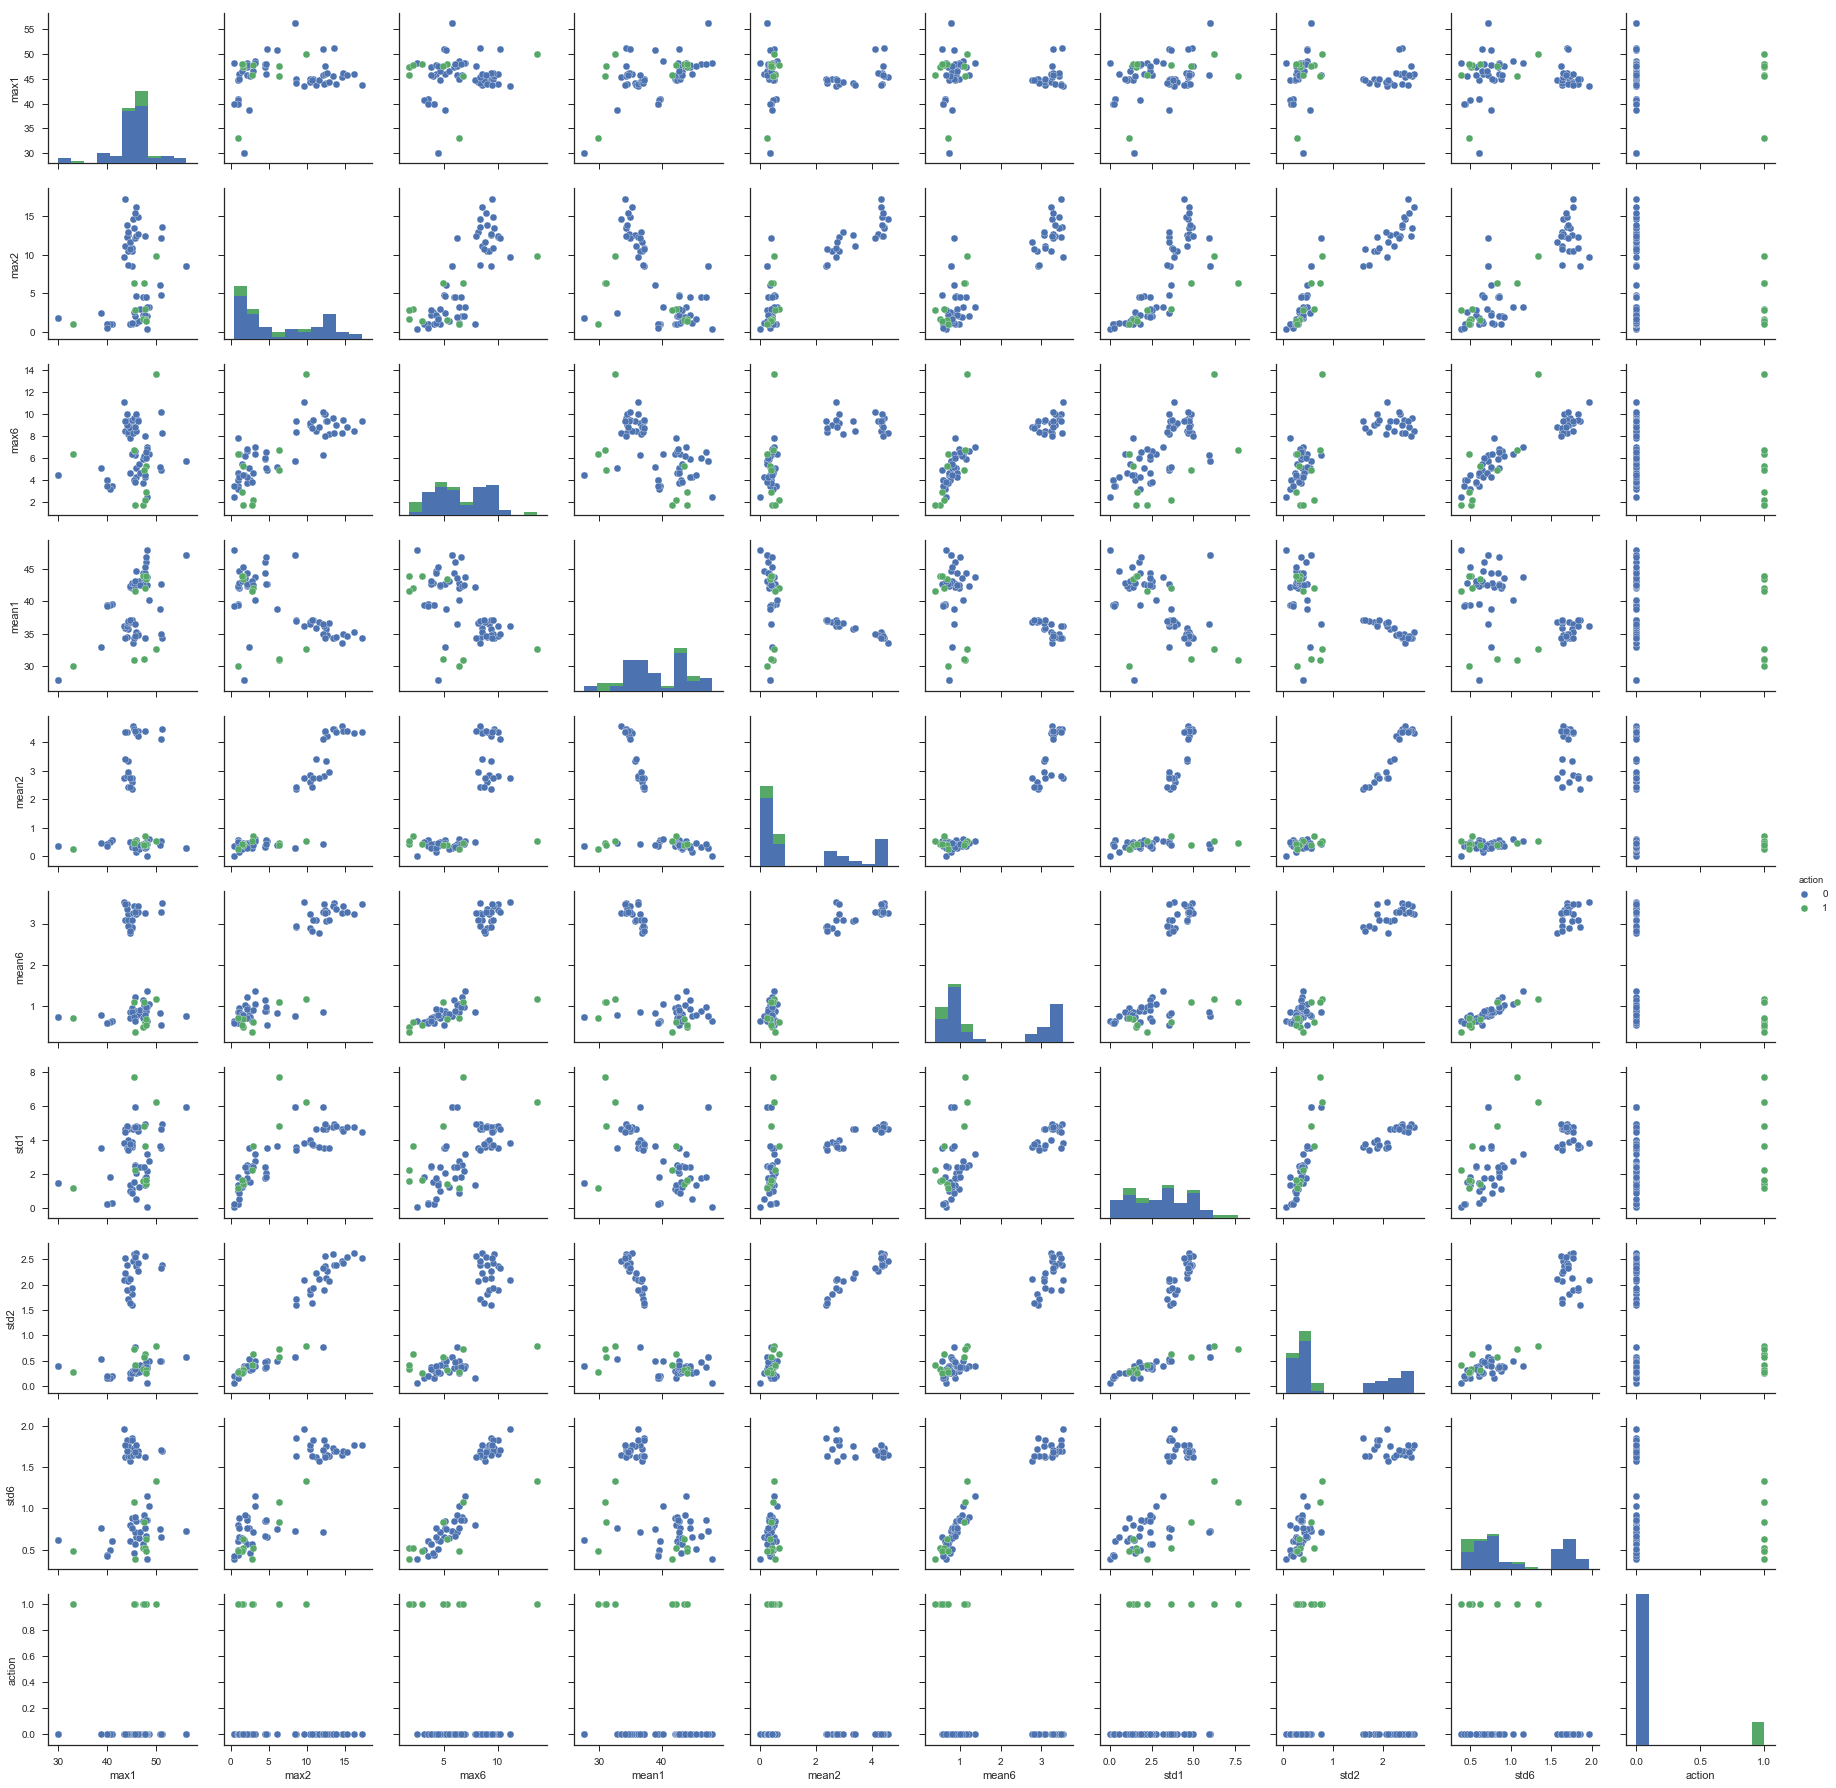

In [25]:
sns.set(style="ticks")
sns.pairplot(df_training_bending_and_other, hue="action")
plt.show()

(d)ii. 

Break each time series in your training set into two (approximately) equal
length time series.

In [26]:
def split_df(dfs,l):
    dfs_split = []
    for df in dfs:
        pace = int(df.shape[0]/l) + 1
        for index in range(0,df.shape[0],pace):
            df_split = df.iloc[index:index + pace,:]
            dfs_split.append(df_split)
    return dfs_split
    
    

In [27]:
bending_dfs_split_2 = split_df(bending_dfs,2)
other_dfs_split_2 = split_df(other_dfs,2)

In [28]:
print(len(bending_dfs_split_2))
print(len(other_dfs_split_2))

18
120


In [29]:
bending_training_features_split_2 = feature_select(bending_dfs_split_2)
other_training_features_split_2 = feature_select(other_dfs_split_2)

In [30]:
bend_action = []
other_action = []
for i in range(0,bending_training_features_split_2.shape[0]+1):
    bend_action.append(1)
for i in range(0,other_training_features_split_2.shape[0]+1):
    other_action.append(0)


bending_training_features_split_2['action'] = pd.Series(bend_action)
other_training_features_split_2['action'] = pd.Series(other_action)

df_training_bending_and_other = pd.concat([bending_training_features_split_2,other_training_features_split_2])

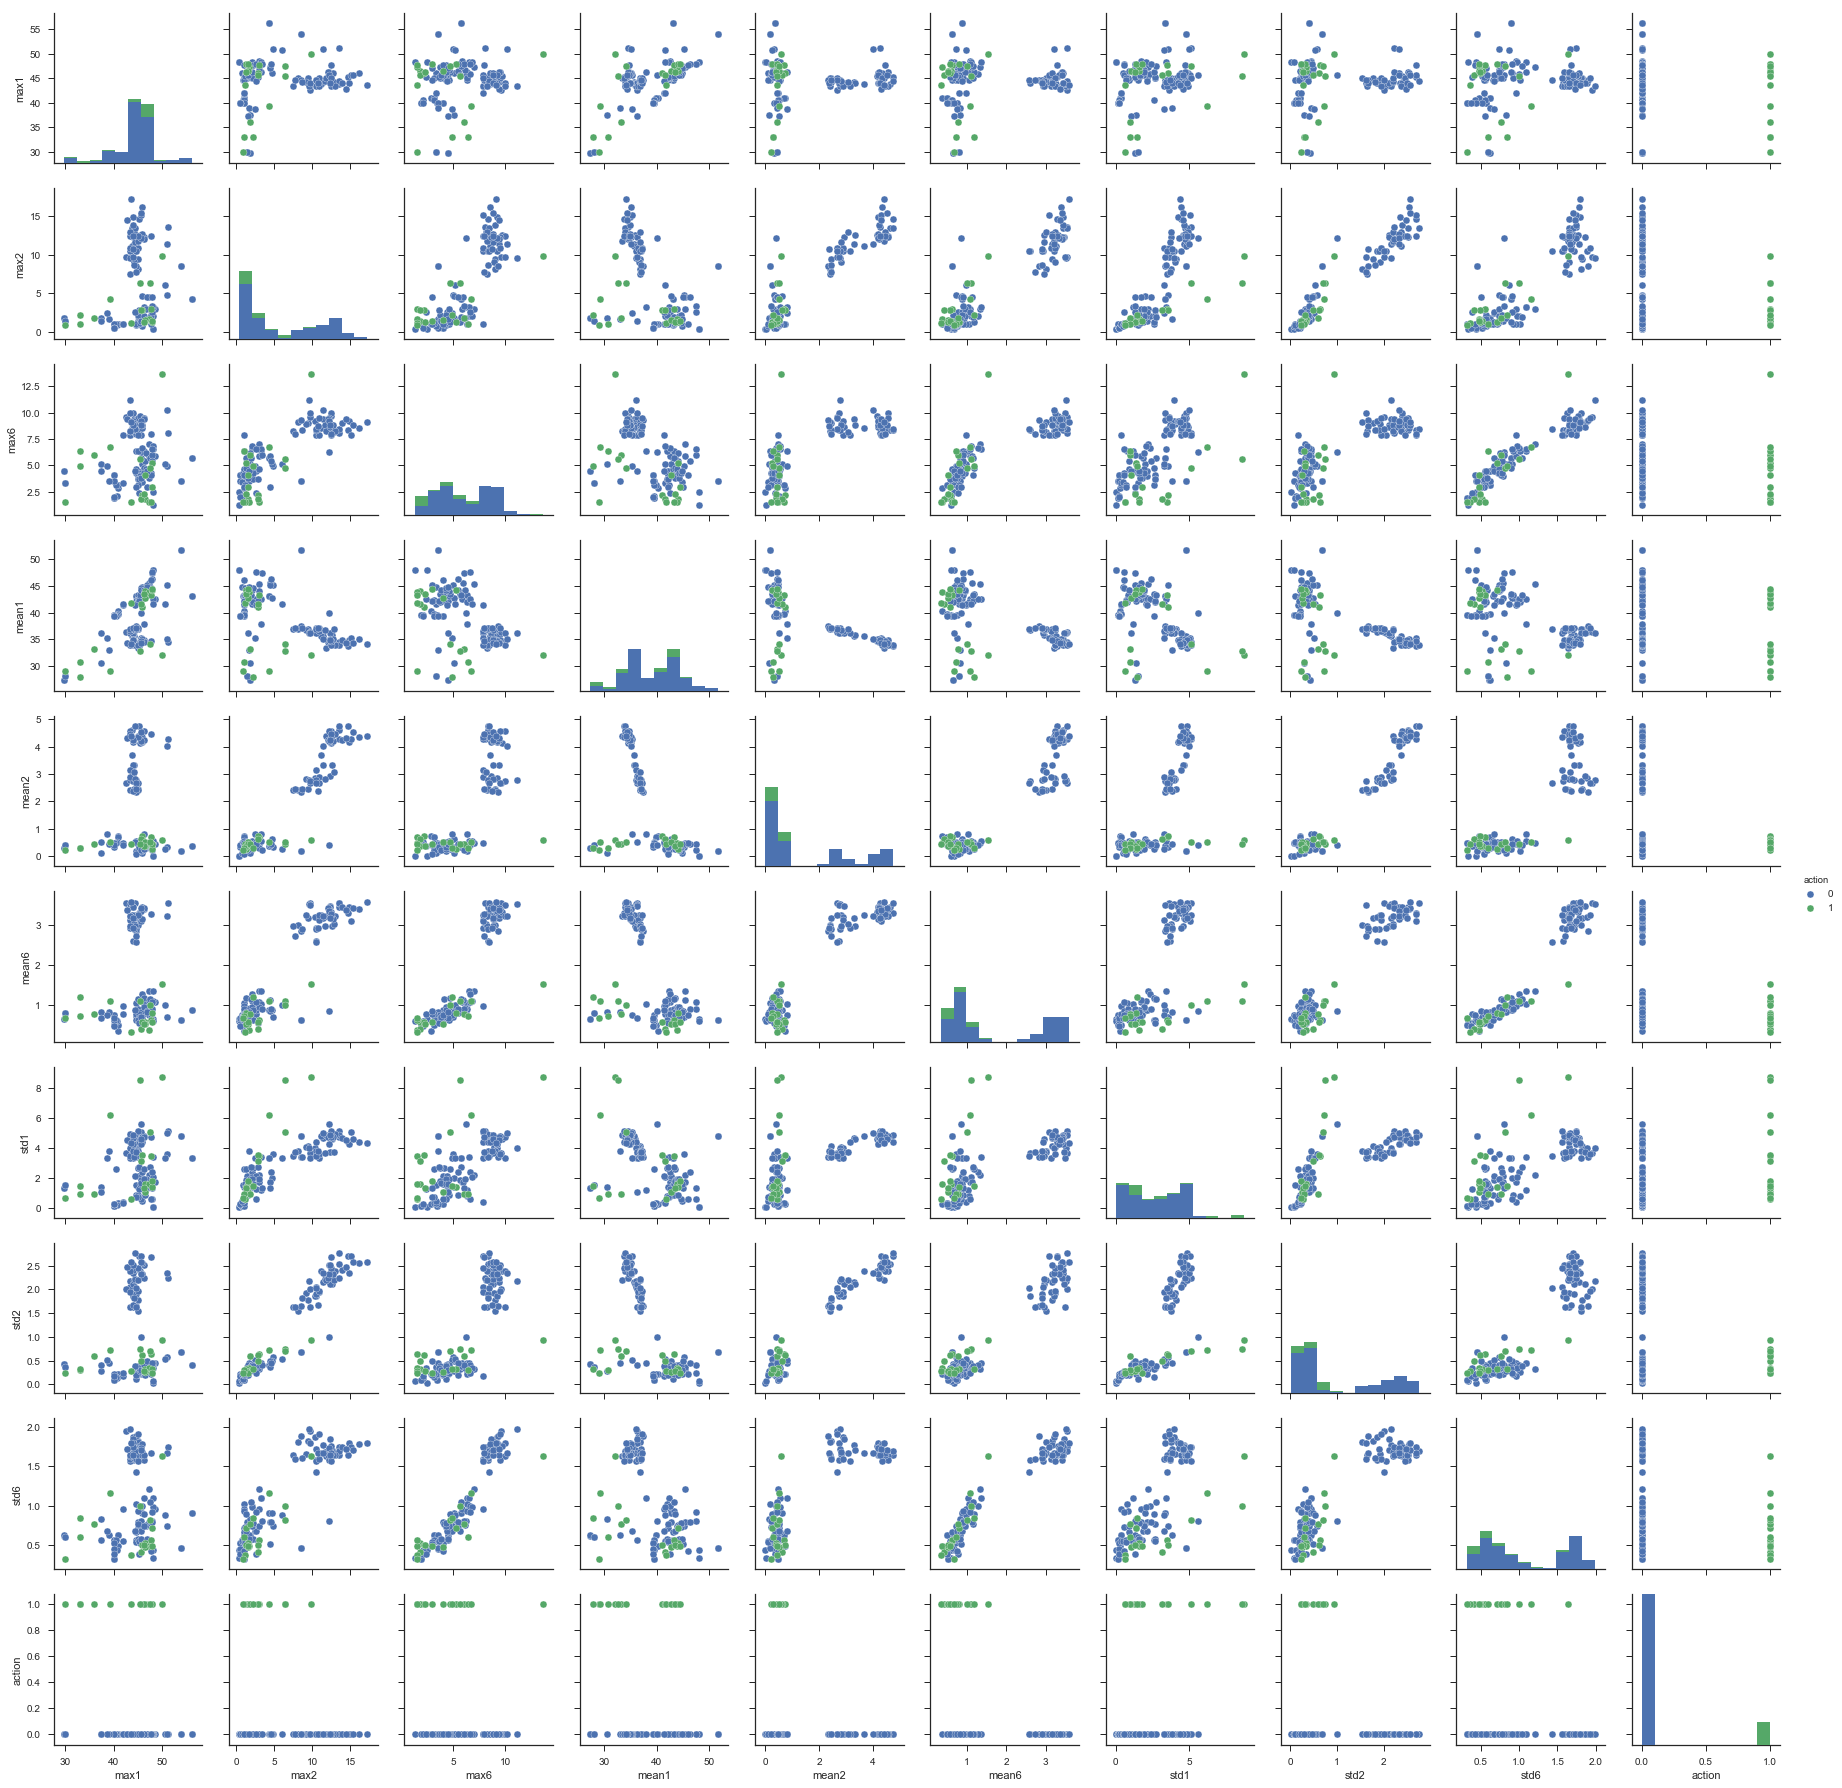

In [31]:
sns.set(style="ticks")
sns.pairplot(df_training_bending_and_other, hue="action")
plt.show()

(d)iii. 

Break each time series and choose the best l and best 10 features.

When using cross-validation in this problem, there are a wrong way and a right way.

Wrong way:Just choose best 10 features, and use CV only for l.

Right way:Use CV both in choosing features and choosing l.

In [32]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [33]:
def feature_selection(df):
    model = LogisticRegression()
    # create the RFE model and select 10 attributes
    rfe = RFE(model,5)
    rfe = rfe.fit(df.iloc[:,0:-1], df['action'])
    return (rfe.support_)

    

In [34]:
def all_features_data(dfs,l,action_class):
    dfs_split = split_df(dfs,l)
    all_features_data = pd.DataFrame(columns=['min1','max1','mean1','median1','std1','1stquart1','3rdquart1',
                                 'min2','max2','mean2','median2','std2','1stquart2','3rdquart2',
                                 'min3','max3','mean3','median3','std3','1stquart3','3rdquart3',
                                 'min4','max4','mean4','median4','std4','1stquart4','3rdquart4',
                                 'min5','max5','mean5','median5','std5','1stquart5','3rdquart5',
                                 'min6','max6','mean6','median6','std6','1stquart6','3rdquart6','action'])
    
    for i in range(0,len(dfs_split)):
        df = dfs_split[i]
        dict = {}
        for j in range(1,7):
            dict['min'+str(j)] = df[df.columns[j]].min(axis = 0)
            dict['max'+str(j)] = df[df.columns[j]].max(axis = 0)
            dict['mean'+str(j)] = df[df.columns[j]].mean(axis = 0)
            dict['median'+str(j)] = df[df.columns[j]].median(axis = 0)
            dict['std'+str(j)] = df[df.columns[j]].std(axis = 0)
            dict['1stquart'+str(j)] = df[df.columns[j]].quantile(0.25)
            dict['3rdquart'+str(j)] = df[df.columns[j]].quantile(0.75)
            dict['action'] = action_class
        all_features_data = all_features_data.append(pd.DataFrame(dict,index=[i + 1]))
    return all_features_data
    
    

In [35]:
def get_score(training_data, test_data):
    logistic = LogisticRegression()
    logistic.fit(training_data.iloc[:,0:-1], training_data['action'])
    return logistic.score(test_data.iloc[:,0:-1], test_data['action'])
    

In [36]:
def CV_for_feature_selection(df_with_all_features):
    size = df_with_all_features.shape[0]
    single_size = int(size/5)
    pieces = [df_with_all_features.iloc[0:single_size,:],df_with_all_features.iloc[single_size:2*single_size,:],
             df_with_all_features.iloc[2*single_size:3*single_size,:],df_with_all_features.iloc[3*single_size:4*single_size,:],
             df_with_all_features.iloc[4*single_size:5*single_size,:]]
    
    train_combinations = [[1,2,3,4],[0,2,3,4],[0,1,3,4],[0,1,2,4],[0,1,2,3]]
    test_combinations = [0,1,2,3]
    f_selected_list = []
    accuracy = []
    
    for i in range(0,len(test_combinations)):
        ind = train_combinations[i]
        
        train_data = pd.concat([pieces[ind[0]],pieces[ind[1]],pieces[ind[2]],pieces[ind[3]]])
        test_data = pieces[i]
        
        
        f_selected = feature_selection(train_data)
        f_selected_list.append(f_selected)
        
        train_selected_data = train_data.iloc[:,f_selected]

        train_selected_data = train_selected_data.assign(action= train_data['action'])

        test_selected_data = test_data.iloc[:,f_selected]
        test_selected_data = test_selected_data.assign(action= test_data['action'])
  
        
        accuracy.append(get_score(train_data, test_data))
        
    po = accuracy.index(max(accuracy))
    return f_selected_list[po]
    

In [37]:
scores = {}
selected_features = []
for l in range(1,16):
    print("Computing l = " + str(l))
    bendings_all_feature = all_features_data(bending_dfs,l,1)
  
    other_all_feature = all_features_data(other_dfs,l,0) 
    # 1 as bending class, 0 as other class
    df_with_all_features = pd.concat([bendings_all_feature,other_all_feature])
    df_with_all_features = df_with_all_features.sample(frac=1).reset_index(drop=True)
    df_with_all_features = df_with_all_features.reindex_axis(['1stquart1', '1stquart2', '1stquart3', '1stquart4', '1stquart5',
       '1stquart6', '3rdquart1', '3rdquart2', '3rdquart3', '3rdquart4',
       '3rdquart5', '3rdquart6', 'max1', 'max2', 'max3', 'max4',
       'max5', 'max6', 'mean1', 'mean2', 'mean3', 'mean4', 'mean5', 'mean6',
       'median1', 'median2', 'median3', 'median4', 'median5', 'median6',
       'min1', 'min2', 'min3', 'min4', 'min5', 'min6', 'std1', 'std2', 'std3',
       'std4', 'std5', 'std6', 'action'],axis = 1)
    
    df_with_all_features['action'] = df_with_all_features['action'].astype(int)
    #df_with_all_features.insert(len(df_with_all_features.columns),'action',test_data['action'])
    f_selected = CV_for_feature_selection(df_with_all_features)
    selected_features.append(f_selected)

    
    
    
    df_selected_features = df_with_all_features.iloc[:,f_selected]
    df_selected_features = df_selected_features.assign(action = df_with_all_features['action'])
    #print(df_selected_features['action'])
    
    logistic = LogisticRegression()
    scores[l] = sum(cross_val_score(logistic, df_selected_features.iloc[:,0:-1],
                               df_selected_features['action'],cv = 5))/(5.0)
    print("Score is " + str(scores[l]))

Computing l = 1
Score is 1.0
Computing l = 2
Score is 0.9708994708994709
Computing l = 3
Score is 0.8696864111498257
Computing l = 4
Score is 0.9240909090909091
Computing l = 5
Score is 0.872463768115942
Computing l = 6
Score is 0.8647663826035851
Computing l = 7
Score is 0.9192654639175257
Computing l = 8
Score is 0.922014742014742
Computing l = 9
Score is 0.8760129032258064
Computing l = 10
Score is 0.872463768115942
Computing l = 11
Score is 0.9275444405716277
Computing l = 12
Score is 0.933574297188755
Computing l = 13
Score is 0.8706703910614525
Computing l = 14
Score is 0.932701244591635
Computing l = 15
Score is 0.8695652173913043


choose L = 1

(d).iv

In [38]:
l=1

In [39]:
df = df_with_all_features.iloc[:,:-1]
features_for_l_1 = df.columns[selected_features[l-1]]

In [40]:
bendings_all_feature = all_features_data(bending_dfs,l,1)
  
other_all_feature = all_features_data(other_dfs,l,0) 
# 1 as bending class, 0 as other class
df_with_all_features = pd.concat([bendings_all_feature,other_all_feature])
df_with_all_features = df_with_all_features.sample(frac=1).reset_index(drop=True)
df_with_all_features = df_with_all_features.reindex_axis(['1stquart1', '1stquart2', '1stquart3', '1stquart4', '1stquart5',
       '1stquart6', '3rdquart1', '3rdquart2', '3rdquart3', '3rdquart4',
       '3rdquart5', '3rdquart6', 'max1', 'max2', 'max3', 'max4',
       'max5', 'max6', 'mean1', 'mean2', 'mean3', 'mean4', 'mean5', 'mean6',
       'median1', 'median2', 'median3', 'median4', 'median5', 'median6',
       'min1', 'min2', 'min3', 'min4', 'min5', 'min6', 'std1', 'std2', 'std3',
       'std4', 'std5', 'std6', 'action'], axis=1)
    

print(features_for_l_1)
df_selected_features = df_with_all_features[features_for_l_1]
df_selected_features = df_selected_features.assign(action = df_with_all_features['action'])
df_selected_features['action'] = df_selected_features['action'].astype(int)
#print(df_selected_features['action'])

logistic = LogisticRegression()
logistic.fit(df_selected_features.iloc[:,0:-1],df_selected_features['action'])
scores = sum(cross_val_score(logistic, df_selected_features.iloc[:,0:-1],
                            df_selected_features['action'],cv = 5))/(5.0)
print("Score is " + str(scores))

Index(['1stquart5', '3rdquart1', 'max2', 'max5', 'min5'], dtype='object')
Score is 1.0


In [41]:
df_selected_features.columns

Index(['1stquart5', '3rdquart1', 'max2', 'max5', 'min5', 'action'], dtype='object')

In [42]:
logistic.predict(df_selected_features.iloc[:,0:-1])

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0])

In [43]:
predict_result = logistic.predict(df_selected_features.iloc[:,0:-1])
(predict_result - df_selected_features['action']).abs().sum() 

0

In [44]:
predict_result.sum()

9

In [45]:
len(predict_result)

69

In [46]:
print("Confusion Matrix")
pd.DataFrame(data={'Class 0(other) Predicted':[60,0],'Class 1(bending) Predicted':[0,9]},
             index=['Class 0(other) Actual','Class 1(bending) Actual'])


Confusion Matrix


,Class 0(other) Predicted,Class 1(bending) Predicted
Class 0(other) Actual,60,0
Class 1(bending) Actual,0,9


In [47]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [48]:
y_score = logistic.decision_function(df_selected_features.iloc[:,0:-1])
fpr, tpr, thresholds  = roc_curve(df_selected_features['action'], y_score)
roc_auc = auc(fpr, tpr)



In [49]:
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

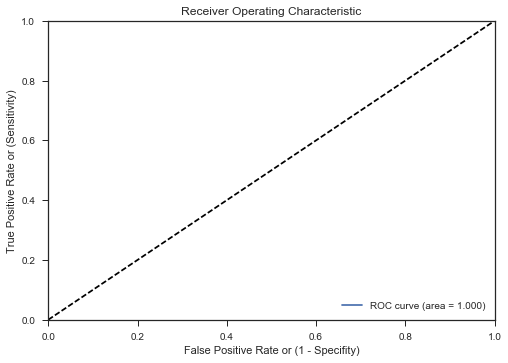

In [50]:
plt.show()

In [51]:
roc_auc

1.0

In [52]:
logistic.coef_

array([[ 0.36519693, -0.70622618, -0.36915585,  0.70737655,  0.45169348]])

In [53]:
import statsmodels.api as sm

In [54]:
logit = sm.Logit(df_selected_features['action'],df_selected_features.iloc[:,:-1])

In [55]:
result = logit.fit()

PerfectSeparationError: Perfect separation detected, results not available

In [56]:
result.summary2()

NameError: name 'result' is not defined

(d).v

In [57]:
len(test_dfs)

19

In [58]:
bending_dfs_test = test_dfs[0:4]
other_dfs_test = test_dfs[4:]

In [59]:
bendings_all_feature = all_features_data(bending_dfs_test,l,1)
  
other_all_feature = all_features_data(other_dfs_test,l,0) 
# 1 as bending class, 0 as other class
df_with_all_features_test = pd.concat([bendings_all_feature,other_all_feature])
df_with_all_features_test = df_with_all_features_test.sample(frac=1).reset_index(drop=True)
df_with_all_features_test = df_with_all_features_test.reindex_axis(['1stquart1', '1stquart2', '1stquart3', '1stquart4', '1stquart5',
       '1stquart6', '3rdquart1', '3rdquart2', '3rdquart3', '3rdquart4',
       '3rdquart5', '3rdquart6', 'max1', 'max2', 'max3', 'max4',
       'max5', 'max6', 'mean1', 'mean2', 'mean3', 'mean4', 'mean5', 'mean6',
       'median1', 'median2', 'median3', 'median4', 'median5', 'median6',
       'min1', 'min2', 'min3', 'min4', 'min5', 'min6', 'std1', 'std2', 'std3',
       'std4', 'std5', 'std6', 'action'], axis=1)
    

print(features_for_l_1)
df_selected_features_test = df_with_all_features_test[features_for_l_1]
df_selected_features_test = df_selected_features_test.assign(action = df_with_all_features_test['action'])
df_selected_features_test['action'] = df_selected_features_test['action'].astype(int)
#print(df_selected_features['action'])



Index(['1stquart5', '3rdquart1', 'max2', 'max5', 'min5'], dtype='object')


In [60]:
predict_result = logistic.predict(df_selected_features_test.iloc[:,0:-1])
predict_result

array([1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0])

In [61]:
predict_result - df_selected_features_test['action']

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
Name: action, dtype: int32

In [62]:
(predict_result - df_selected_features_test['action']).abs().sum()


0

In [63]:
1-(predict_result - df_selected_features_test['action']).abs().sum()/(len(predict_result))

1.0

Test error for L = 1 is also 0. 

vi. Do your classes seem to be well-separated to cause instability in calculating
logistic regression parameters?

Yes, because the test error and CV error are all 0, the classes are well-separated.

vii. From the confusion matrices you obtained, do you see imbalanced classes?
If yes, build a logistic regression model based on case-control sampling and
adjust its parameters. Report the confusion matrix, ROC, and AUC of the
model.

There is siginificant imbalance in classes, for bending class only has 9 instances, but other class has   60 instances.

Case-control sampling

In [64]:
extended_dfs = []

for df in bending_dfs:
    for i in range(0,7):
        extended_dfs.append(df)

len(extended_dfs)

63

In [65]:
bendings_all_feature = all_features_data(extended_dfs,l,1)
  
other_all_feature = all_features_data(other_dfs,l,0) 
# 1 as bending class, 0 as other class
df_with_all_features = pd.concat([bendings_all_feature,other_all_feature])
df_with_all_features = df_with_all_features.sample(frac=1).reset_index(drop=True)
df_with_all_features = df_with_all_features.reindex_axis(['1stquart1', '1stquart2', '1stquart3', '1stquart4', '1stquart5',
       '1stquart6', '3rdquart1', '3rdquart2', '3rdquart3', '3rdquart4',
       '3rdquart5', '3rdquart6', 'max1', 'max2', 'max3', 'max4',
       'max5', 'max6', 'mean1', 'mean2', 'mean3', 'mean4', 'mean5', 'mean6',
       'median1', 'median2', 'median3', 'median4', 'median5', 'median6',
       'min1', 'min2', 'min3', 'min4', 'min5', 'min6', 'std1', 'std2', 'std3',
       'std4', 'std5', 'std6', 'action'], axis=1)
    

print(features_for_l_1)
df_selected_features = df_with_all_features[features_for_l_1]
df_selected_features = df_selected_features.assign(action = df_with_all_features['action'])
df_selected_features['action'] = df_selected_features['action'].astype(int)
#print(df_selected_features['action'])

logistic = LogisticRegression()
logistic.fit(df_selected_features.iloc[:,0:-1],df_selected_features['action'])
scores = sum(cross_val_score(logistic, df_selected_features.iloc[:,0:-1],
                            df_selected_features['action'],cv = 5))/(5.0)
print("Score is " + str(scores))

Index(['1stquart5', '3rdquart1', 'max2', 'max5', 'min5'], dtype='object')
Score is 1.0


In [66]:
predict_result = logistic.predict(df_selected_features.iloc[:,0:-1])
(predict_result - df_selected_features['action']).abs().sum() 

0

In [67]:
predict_result.sum()

63

In [68]:
len(predict_result)

123

In [69]:
print("Confusion Matrix")
pd.DataFrame(data={'Class 0(other) Predicted':[60,0],'Class 1(bending) Predicted':[0,63]},
             index=['Class 0(other) Actual','Class 1(bending) Actual'])



Confusion Matrix


,Class 0(other) Predicted,Class 1(bending) Predicted
Class 0(other) Actual,60,0
Class 1(bending) Actual,0,63


In [70]:
y_score = logistic.decision_function(df_selected_features.iloc[:,0:-1])
fpr, tpr, thresholds  = roc_curve(df_selected_features['action'], y_score)
roc_auc = auc(fpr, tpr)


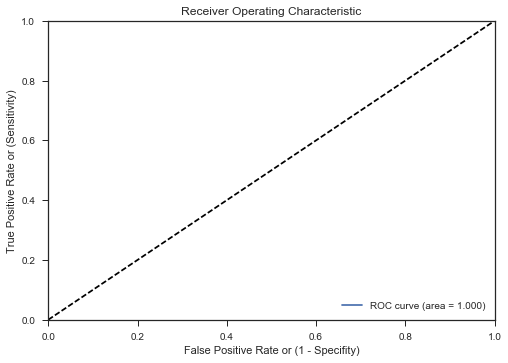

In [71]:
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [72]:
roc_auc

1.0

(e) Binary Classication Using L1-penalized logistic regression

i.Repeat 1(d)iii using L1-penalized logistic regression

Using sklearn L1 penalty, with double loop CV.

In [73]:
def CV_for_L1_penalty(df_with_all_features):

    C_collections = [625,125,25,5,1,0.2]
    scores = []
    
    for c in C_collections:
        
        logistic = LogisticRegression(penalty = 'l1', C = c)
        logistic.fit(df_with_all_features.iloc[:,0:-1],df_with_all_features['action'])
        score = sum(cross_val_score(logistic, df_with_all_features.iloc[:,0:-1],
                                    df_with_all_features['action'],cv = 5))/(5.0)
        
        scores.append(score)
        
    po = scores.index(max(scores))
    return max(scores), C_collections[po]  

Using Standardized data to CV for choosing L and C.

In [74]:
def standardize(df):
    df = df.reindex_axis(['1stquart1', '1stquart2', '1stquart3', '1stquart4', '1stquart5',
       '1stquart6', '3rdquart1', '3rdquart2', '3rdquart3', '3rdquart4',
       '3rdquart5', '3rdquart6', 'max1', 'max2', 'max3', 'max4',
       'max5', 'max6', 'mean1', 'mean2', 'mean3', 'mean4', 'mean5', 'mean6',
       'median1', 'median2', 'median3', 'median4', 'median5', 'median6',
       'min1', 'min2', 'min3', 'min4', 'min5', 'min6', 'std1', 'std2', 'std3',
       'std4', 'std5', 'std6', 'action'], axis=1)
    features = df.iloc[:,:-1] 
    df_std = df
    df_std.iloc[:,:-1] = (features - features.mean()) / (features.max() - features.min() +0.00000000001)
    
    return df_std

In [75]:
scores = {}
C_for_each = []
for l in range(1,21):
    print("Computing l = " + str(l))
    bendings_all_feature = all_features_data(bending_dfs,l,1)
    #bendings_std = standardize(bendings_all_feature)
    #print(bendings_std)
    
    other_all_feature = all_features_data(other_dfs,l,0) 
    #other_std = standardize(other_all_feature)
    
    
    # 1 as bending class, 0 as other class
    #df_with_all_features = pd.concat([bendings_std,other_std])
    df_with_all_features = pd.concat([bendings_all_feature,other_all_feature])
    df_with_all_features = df_with_all_features.sample(frac=1).reset_index(drop=True)
    df_with_all_features = df_with_all_features.reindex_axis(['1stquart1', '1stquart2', '1stquart3', '1stquart4', '1stquart5',
       '1stquart6', '3rdquart1', '3rdquart2', '3rdquart3', '3rdquart4',
       '3rdquart5', '3rdquart6', 'max1', 'max2', 'max3', 'max4',
       'max5', 'max6', 'mean1', 'mean2', 'mean3', 'mean4', 'mean5', 'mean6',
       'median1', 'median2', 'median3', 'median4', 'median5', 'median6',
       'min1', 'min2', 'min3', 'min4', 'min5', 'min6', 'std1', 'std2', 'std3',
       'std4', 'std5', 'std6', 'action'], axis=1)
    
    df_with_all_features['action'] = df_with_all_features['action'].astype(int)

    scores[l], c = CV_for_L1_penalty(df_with_all_features)   
    C_for_each.append(c)
    
    print("Score is " + str(scores[l]))
    print("C is " + str(c))
    

Computing l = 1
Score is 0.9857142857142858
C is 25
Computing l = 2
Score is 0.9497354497354497
C is 0.2
Computing l = 3
Score is 0.9613240418118465
C is 5
Computing l = 4
Score is 0.9420779220779221
C is 1
Computing l = 5
Score is 0.9536231884057971
C is 1
Computing l = 6
Score is 0.9444607699089038
C is 0.2
Computing l = 7
Score is 0.9399699312714777
C is 1
Computing l = 8
Score is 0.9529074529074529
C is 5
Computing l = 9
Score is 0.9500645161290322
C is 5
Computing l = 10
Score is 0.9478260869565217
C is 1
Computing l = 11
Score is 0.9407023353084698
C is 1
Computing l = 12
Score is 0.949258853596203
C is 1
Computing l = 13
Score is 0.9431843575418994
C is 0.2
Computing l = 14
Score is 0.9430585972971528
C is 0.2
Computing l = 15
Score is 0.9468599033816425
C is 1
Computing l = 16
Score is 0.9420320855614973
C is 1
Computing l = 17
Score is 0.943738861611202
C is 1
Computing l = 18
Score is 0.9436520274646976
C is 1
Computing l = 19
Score is 0.9435695004789133
C is 1
Computing l = 

choose L = 1, C = 25 (lamda = (1/C) = 0.04)

In [76]:
l = 1
c = 25

In [77]:
extended_dfs = []

for df in bending_dfs:
    for i in range(0,7):
        extended_dfs.append(df)

len(extended_dfs)


63

In [78]:
bendings_all_feature = all_features_data(extended_dfs,l,1)
  
other_all_feature = all_features_data(other_dfs,l,0) 
# 1 as bending class, 0 as other class
df_with_all_features = pd.concat([bendings_all_feature,other_all_feature])
df_with_all_features = df_with_all_features.sample(frac=1).reset_index(drop=True)
df_with_all_features = df_with_all_features.reindex_axis(['1stquart1', '1stquart2', '1stquart3', '1stquart4', '1stquart5',
       '1stquart6', '3rdquart1', '3rdquart2', '3rdquart3', '3rdquart4',
       '3rdquart5', '3rdquart6', 'max1', 'max2', 'max3', 'max4',
       'max5', 'max6', 'mean1', 'mean2', 'mean3', 'mean4', 'mean5', 'mean6',
       'median1', 'median2', 'median3', 'median4', 'median5', 'median6',
       'min1', 'min2', 'min3', 'min4', 'min5', 'min6', 'std1', 'std2', 'std3',
       'std4', 'std5', 'std6', 'action'], axis=1)
df_with_all_features['action'] = df_with_all_features['action'].astype(int)

logistic = LogisticRegression(penalty='l1', C=c)
logistic.fit(df_with_all_features.iloc[:,0:-1],df_with_all_features['action'])
#logistic = LogisticRegression()
scores[l] = sum(cross_val_score(logistic, df_with_all_features.iloc[:,0:-1],
                           df_with_all_features['action'],cv = 5))/(5.0)
print("Score is " + str(scores[l]))
print("C is " + str(c))

Score is 1.0
C is 25


In [79]:
predict_result = logistic.predict(df_with_all_features.iloc[:,0:-1])
(predict_result - df_with_all_features['action']).abs().sum() 

0

In [80]:
predict_result.sum()

63

In [81]:
len(predict_result)

123

In [82]:
print("Confusion Matrix")
pd.DataFrame(data={'Class 0(other) Predicted':[60,0],'Class 1(bending) Predicted':[0,63]},
             index=['Class 0(other) Actual','Class 1(bending) Actual'])



Confusion Matrix


,Class 0(other) Predicted,Class 1(bending) Predicted
Class 0(other) Actual,60,0
Class 1(bending) Actual,0,63


In [83]:
y_score = logistic.decision_function(df_with_all_features.iloc[:,0:-1])
fpr, tpr, thresholds  = roc_curve(df_with_all_features['action'], y_score)
roc_auc = auc(fpr, tpr)


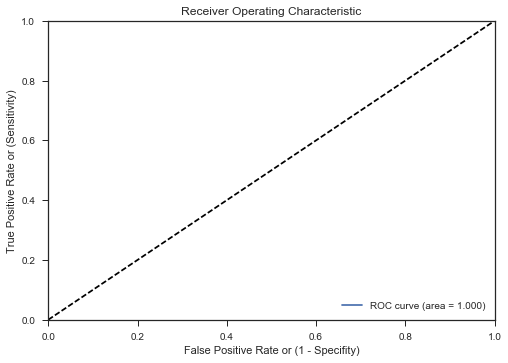

In [84]:
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [85]:
roc_auc

1.0

In [86]:
bendings_all_feature = all_features_data(bending_dfs_test,l,1)
  
other_all_feature = all_features_data(other_dfs_test,l,0) 
# 1 as bending class, 0 as other class
df_with_all_features_test = pd.concat([bendings_all_feature,other_all_feature])
df_with_all_features_test = df_with_all_features_test.sample(frac=1).reset_index(drop=True)
df_with_all_features_test = df_with_all_features_test.reindex_axis(['1stquart1', '1stquart2', '1stquart3', '1stquart4', '1stquart5',
       '1stquart6', '3rdquart1', '3rdquart2', '3rdquart3', '3rdquart4',
       '3rdquart5', '3rdquart6', 'max1', 'max2', 'max3', 'max4',
       'max5', 'max6', 'mean1', 'mean2', 'mean3', 'mean4', 'mean5', 'mean6',
       'median1', 'median2', 'median3', 'median4', 'median5', 'median6',
       'min1', 'min2', 'min3', 'min4', 'min5', 'min6', 'std1', 'std2', 'std3',
       'std4', 'std5', 'std6', 'action'], axis=1)
    


In [87]:
predict_result = logistic.predict(df_with_all_features_test.iloc[:,0:-1])
(predict_result - df_with_all_features_test['action']).abs().sum()

0

In [88]:
1-(predict_result - df_with_all_features_test['action']).abs().sum()/(len(predict_result))

1.0

ii. Compare the L1-penalized with variable selection using p-values. Which one performs better? Which one is easier to implement?

Both perform very well, but the second method (L1-penalized) is much easy to implement.


(f) Multi-class Classification (The Realistic Case)

In [89]:
bending1_dfs_test = test_dfs[0:2]
bending2_dfs_test = test_dfs[2:4]
cycling_dfs_test = test_dfs[4:7]
lying_dfs_test = test_dfs[7:10]
sitting_dfs_test = test_dfs[10:13]
standing_dfs_test = test_dfs[13:16]
walking_dfs_test = test_dfs[16:19]

test_dfs_with_actions = [bending1_dfs_test,bending2_dfs_test,cycling_dfs_test,lying_dfs_test,sitting_dfs_test,
                         standing_dfs_test,walking_dfs_test]

In [90]:
bending1_dfs_train = train_dfs[0:5]
bending2_dfs_train = train_dfs[5:9]
cycling_dfs_train = train_dfs[9:21]
lying_dfs_train = train_dfs[21:33]
sitting_dfs_train = train_dfs[33:45]
standing_dfs_train = train_dfs[45:57]
walking_dfs_train = train_dfs[57:69]

train_dfs_with_actions = [bending1_dfs_train,bending2_dfs_train,cycling_dfs_train,lying_dfs_train,sitting_dfs_train,
                          standing_dfs_train,walking_dfs_train]


In [91]:
scores = {}
C_for_each = {}
for l in range(1,16):
    print("Computing l = " + str(l))
    bending1_all_feature = all_features_data(bending1_dfs_train,l,0)
    bending2_all_feature = all_features_data(bending2_dfs_train,l,1)
    cycling_all_feature = all_features_data(cycling_dfs_train,l,2)
    lying_all_feature = all_features_data(lying_dfs_train,l,3)
    sitting_all_feature = all_features_data(sitting_dfs_train,l,4)
    standing_all_feature = all_features_data(standing_dfs_train,l,5)
    walking_all_feature = all_features_data(walking_dfs_train,l,6)

    
    df_with_all_features = pd.concat([bendings_all_feature,bending2_all_feature,
                                      cycling_all_feature,lying_all_feature,sitting_all_feature,
                                      standing_all_feature,walking_all_feature])
    df_with_all_features = df_with_all_features.sample(frac=1).reset_index(drop=True)
    df_with_all_features = df_with_all_features.reindex_axis(['1stquart1', '1stquart2', '1stquart3', '1stquart4', '1stquart5',
       '1stquart6', '3rdquart1', '3rdquart2', '3rdquart3', '3rdquart4',
       '3rdquart5', '3rdquart6', 'max1', 'max2', 'max3', 'max4',
       'max5', 'max6', 'mean1', 'mean2', 'mean3', 'mean4', 'mean5', 'mean6',
       'median1', 'median2', 'median3', 'median4', 'median5', 'median6',
       'min1', 'min2', 'min3', 'min4', 'min5', 'min6', 'std1', 'std2', 'std3',
       'std4', 'std5', 'std6', 'action'], axis=1)
    
    df_with_all_features['action'] = df_with_all_features['action'].astype(int)
  
    scores[l], c = CV_for_L1_penalty(df_with_all_features)   
    C_for_each[l] = c
    
    print("Score is " + str(scores[l]))
    print("C is " + str(c))
    
    

Computing l = 1
Score is 0.9229946524064172
C is 25
Computing l = 2
Score is 0.8634680134680135
C is 1
Computing l = 3
Score is 0.8562200956937799
C is 1
Computing l = 4
Score is 0.8432350718065005
C is 5
Computing l = 5
Score is 0.8611057692307693
C is 625
Computing l = 6
Score is 0.8532540610786224
C is 5
Computing l = 7
Score is 0.8715280169779664
C is 5
Computing l = 8
Score is 0.8586056644880176
C is 0.2
Computing l = 9
Score is 0.8723263836808159
C is 1
Computing l = 10
Score is 0.8401405038759691
C is 0.2
Computing l = 11
Score is 0.8457444093985895
C is 1
Computing l = 12
Score is 0.84968899917287
C is 1
Computing l = 13
Score is 0.8394788456150183
C is 1
Computing l = 14
Score is 0.8398336127149687
C is 0.2
Computing l = 15
Score is 0.8422873488773748
C is 0.2


In [92]:
scores

{1: 0.9229946524064172,
 2: 0.8634680134680135,
 3: 0.8562200956937799,
 4: 0.8432350718065005,
 5: 0.8611057692307693,
 6: 0.8532540610786224,
 7: 0.8715280169779664,
 8: 0.8586056644880176,
 9: 0.8723263836808159,
 10: 0.8401405038759691,
 11: 0.8457444093985895,
 12: 0.84968899917287,
 13: 0.8394788456150183,
 14: 0.8398336127149687,
 15: 0.8422873488773748}

In [93]:
C_for_each

{1: 25,
 2: 1,
 3: 1,
 4: 5,
 5: 625,
 6: 5,
 7: 5,
 8: 0.2,
 9: 1,
 10: 0.2,
 11: 1,
 12: 1,
 13: 1,
 14: 0.2,
 15: 0.2}

choose L = 1, C = 25

In [95]:
l = 1
c = 25

In [96]:
bending1_all_feature = all_features_data(bending1_dfs_train,l,0)
bending2_all_feature = all_features_data(bending2_dfs_train,l,1)
cycling_all_feature = all_features_data(cycling_dfs_train,l,2)
lying_all_feature = all_features_data(lying_dfs_train,l,3)
sitting_all_feature = all_features_data(sitting_dfs_train,l,4)
standing_all_feature = all_features_data(standing_dfs_train,l,5)
walking_all_feature = all_features_data(walking_dfs_train,l,6)


df_with_all_features = pd.concat([bending1_all_feature,bending2_all_feature,
                                  cycling_all_feature,lying_all_feature,sitting_all_feature,
                                  standing_all_feature,walking_all_feature])
df_with_all_features = df_with_all_features.sample(frac=1).reset_index(drop=True)
df_with_all_features = df_with_all_features.reindex_axis(['1stquart1', '1stquart2', '1stquart3', '1stquart4', '1stquart5',
   '1stquart6', '3rdquart1', '3rdquart2', '3rdquart3', '3rdquart4',
   '3rdquart5', '3rdquart6', 'max1', 'max2', 'max3', 'max4',
   'max5', 'max6', 'mean1', 'mean2', 'mean3', 'mean4', 'mean5', 'mean6',
   'median1', 'median2', 'median3', 'median4', 'median5', 'median6',
   'min1', 'min2', 'min3', 'min4', 'min5', 'min6', 'std1', 'std2', 'std3',
   'std4', 'std5', 'std6', 'action'], axis=1)

df_with_all_features['action'] = df_with_all_features['action'].astype(int)
y = label_binarize(df_with_all_features['action'], classes=[0, 1, 2, 3, 4, 5, 6])

logistic = LogisticRegression(penalty = 'l1', C = c)
OVS = OneVsRestClassifier(logistic)
OVS.fit(df_with_all_features.iloc[:,0:-1], y)
#print(df_with_all_features.shape)
#print(y)
#logistic.fit(df_with_all_features.iloc[:,0:-1],y)



OneVsRestClassifier(estimator=LogisticRegression(C=25, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          n_jobs=1)

In [97]:
fpr = {}
tpr = {}
roc_auc = {}


bending1_all_feature = all_features_data(bending1_dfs_test,l,0)
bending2_all_feature = all_features_data(bending2_dfs_test,l,1)
cycling_all_feature = all_features_data(cycling_dfs_test,l,2)
lying_all_feature = all_features_data(lying_dfs_test,l,3)
sitting_all_feature = all_features_data(sitting_dfs_test,l,4)
standing_all_feature = all_features_data(standing_dfs_test,l,5)
walking_all_feature = all_features_data(walking_dfs_test,l,6)

df_with_all_features = pd.concat([bending1_all_feature,bending2_all_feature,
                                  cycling_all_feature,lying_all_feature,sitting_all_feature,
                                  standing_all_feature,walking_all_feature])
df_with_all_features = df_with_all_features.sample(frac=1).reset_index(drop=True)
df_with_all_features = df_with_all_features.reindex_axis(['1stquart1', '1stquart2', '1stquart3', '1stquart4', '1stquart5',
   '1stquart6', '3rdquart1', '3rdquart2', '3rdquart3', '3rdquart4',
   '3rdquart5', '3rdquart6', 'max1', 'max2', 'max3', 'max4',
   'max5', 'max6', 'mean1', 'mean2', 'mean3', 'mean4', 'mean5', 'mean6',
   'median1', 'median2', 'median3', 'median4', 'median5', 'median6',
   'min1', 'min2', 'min3', 'min4', 'min5', 'min6', 'std1', 'std2', 'std3',
   'std4', 'std5', 'std6', 'action'], axis=1)

df_with_all_features['action'] = df_with_all_features['action'].astype(int)
y = label_binarize(df_with_all_features['action'], classes=[0, 1, 2, 3, 4, 5, 6])

y_score = OVS.decision_function(df_with_all_features.iloc[:,0:-1])
for i in range(0,7):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

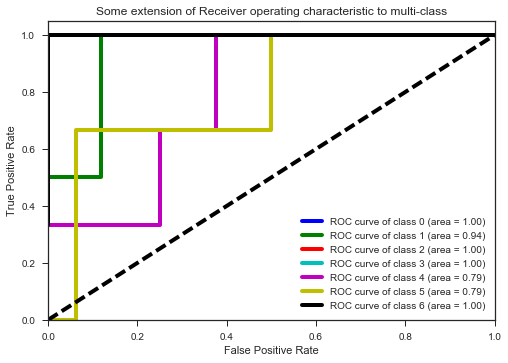

In [98]:
# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(0,7)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(0,7):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 7


#colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
colors = cycle(['b','g','r','c','m','y','k'])
for i, color in zip(range(0,7), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=4,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


ii. Repeat 1(f)i using a Na¨ıve Bayes’ classifier. Use both Gaussian and Multinomial priors and compare the results. 

In [99]:
from sklearn.naive_bayes import GaussianNB

In [100]:
scores = {}
for l in range(1,16):
    print("Computing l = " + str(l))
    bending1_all_feature = all_features_data(bending1_dfs_train,l,1)
    bending2_all_feature = all_features_data(bending2_dfs_train,l,2)
    cycling_all_feature = all_features_data(cycling_dfs_train,l,3)
    lying_all_feature = all_features_data(lying_dfs_train,l,4)
    sitting_all_feature = all_features_data(sitting_dfs_train,l,5)
    standing_all_feature = all_features_data(standing_dfs_train,l,6)
    walking_all_feature = all_features_data(walking_dfs_train,l,7)

    
    df_with_all_features = pd.concat([bendings_all_feature,bending2_all_feature,
                                      cycling_all_feature,lying_all_feature,sitting_all_feature,
                                      standing_all_feature,walking_all_feature])
    df_with_all_features = df_with_all_features.sample(frac=1).reset_index(drop=True)
    df_with_all_features = df_with_all_features.reindex_axis(['1stquart1', '1stquart2', '1stquart3', '1stquart4', '1stquart5',
       '1stquart6', '3rdquart1', '3rdquart2', '3rdquart3', '3rdquart4',
       '3rdquart5', '3rdquart6', 'max1', 'max2', 'max3', 'max4',
       'max5', 'max6', 'mean1', 'mean2', 'mean3', 'mean4', 'mean5', 'mean6',
       'median1', 'median2', 'median3', 'median4', 'median5', 'median6',
       'min1', 'min2', 'min3', 'min4', 'min5', 'min6', 'std1', 'std2', 'std3',
       'std4', 'std5', 'std6', 'action'], axis=1)
    
    df_with_all_features['action'] = df_with_all_features['action'].astype(int)
  
    GNB = GaussianNB()
    scores[l] = sum(cross_val_score(GNB, df_with_all_features.iloc[:,0:-1],
                           df_with_all_features['action'],cv = 5))/(5.0)

    
    print("Score is " + str(scores[l]))

Computing l = 1


F:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Score is 0.814313725490196
Computing l = 2


F:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Score is 0.9042328042328043
Computing l = 3


F:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Score is 0.8223399881294619
Computing l = 4


F:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Score is 0.8517669896241324
Computing l = 5


F:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Score is 0.8457692307692308
Computing l = 6


F:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Score is 0.8303355987566514
Computing l = 7


F:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Score is 0.8245248868778281
Computing l = 8


F:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Score is 0.8311341499655391
Computing l = 9


F:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Score is 0.8330927256158199
Computing l = 10


F:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Score is 0.8027858527131784
Computing l = 11


F:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Score is 0.7995966302563005
Computing l = 12


F:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Score is 0.8029361444646138
Computing l = 13


F:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Score is 0.7920630422082044
Computing l = 14


F:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Score is 0.7797814022598685
Computing l = 15
Score is 0.7904468911917097


F:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


In [101]:
scores

{1: 0.814313725490196,
 2: 0.9042328042328043,
 3: 0.8223399881294619,
 4: 0.8517669896241324,
 5: 0.8457692307692308,
 6: 0.8303355987566514,
 7: 0.8245248868778281,
 8: 0.8311341499655391,
 9: 0.8330927256158199,
 10: 0.8027858527131784,
 11: 0.7995966302563005,
 12: 0.8029361444646138,
 13: 0.7920630422082044,
 14: 0.7797814022598685,
 15: 0.7904468911917097}

In [103]:
l=2

In [104]:
bending1_all_feature = all_features_data(bending1_dfs_train,l,0)
bending2_all_feature = all_features_data(bending2_dfs_train,l,1)
cycling_all_feature = all_features_data(cycling_dfs_train,l,2)
lying_all_feature = all_features_data(lying_dfs_train,l,3)
sitting_all_feature = all_features_data(sitting_dfs_train,l,4)
standing_all_feature = all_features_data(standing_dfs_train,l,5)
walking_all_feature = all_features_data(walking_dfs_train,l,6)


df_with_all_features = pd.concat([bending1_all_feature,bending2_all_feature,
                                  cycling_all_feature,lying_all_feature,sitting_all_feature,
                                  standing_all_feature,walking_all_feature])
df_with_all_features = df_with_all_features.sample(frac=1).reset_index(drop=True)
df_with_all_features = df_with_all_features.reindex_axis(['1stquart1', '1stquart2', '1stquart3', '1stquart4', '1stquart5',
   '1stquart6', '3rdquart1', '3rdquart2', '3rdquart3', '3rdquart4',
   '3rdquart5', '3rdquart6', 'max1', 'max2', 'max3', 'max4',
   'max5', 'max6', 'mean1', 'mean2', 'mean3', 'mean4', 'mean5', 'mean6',
   'median1', 'median2', 'median3', 'median4', 'median5', 'median6',
   'min1', 'min2', 'min3', 'min4', 'min5', 'min6', 'std1', 'std2', 'std3',
   'std4', 'std5', 'std6', 'action'], axis=1)

df_with_all_features['action'] = df_with_all_features['action'].astype(int)
y = label_binarize(df_with_all_features['action'], classes=[0, 1, 2, 3, 4, 5, 6])

GNB = GaussianNB()

OVS = OneVsRestClassifier(GNB)
OVS.fit(df_with_all_features.iloc[:,0:-1], y)
#print(df_with_all_features.shape)
#print(y)
#logistic.fit(df_with_all_features.iloc[:,0:-1],y)



OneVsRestClassifier(estimator=GaussianNB(priors=None), n_jobs=1)

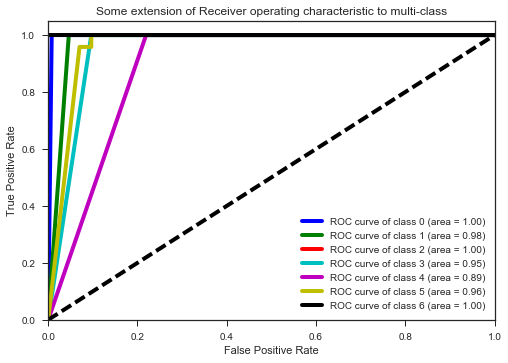

In [105]:
fpr = {}
tpr = {}
roc_auc = {}

y_score = OVS.predict_proba(df_with_all_features.iloc[:,0:-1])
for i in range(0,7):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(0,7)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(0,7):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 7


#colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
colors = cycle(['b','g','r','c','m','y','k'])
for i, color in zip(range(0,7), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=4,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [106]:
from sklearn.naive_bayes import MultinomialNB

In [107]:
scores = {}
for l in range(1,16):
    print("Computing l = " + str(l))
    bending1_all_feature = all_features_data(bending1_dfs_train,l,1)
    bending2_all_feature = all_features_data(bending2_dfs_train,l,2)
    cycling_all_feature = all_features_data(cycling_dfs_train,l,3)
    lying_all_feature = all_features_data(lying_dfs_train,l,4)
    sitting_all_feature = all_features_data(sitting_dfs_train,l,5)
    standing_all_feature = all_features_data(standing_dfs_train,l,6)
    walking_all_feature = all_features_data(walking_dfs_train,l,7)

    
    df_with_all_features = pd.concat([bendings_all_feature,bending2_all_feature,
                                      cycling_all_feature,lying_all_feature,sitting_all_feature,
                                      standing_all_feature,walking_all_feature])
    df_with_all_features = df_with_all_features.sample(frac=1).reset_index(drop=True)
    df_with_all_features = df_with_all_features.reindex_axis(['1stquart1', '1stquart2', '1stquart3', '1stquart4', '1stquart5',
       '1stquart6', '3rdquart1', '3rdquart2', '3rdquart3', '3rdquart4',
       '3rdquart5', '3rdquart6', 'max1', 'max2', 'max3', 'max4',
       'max5', 'max6', 'mean1', 'mean2', 'mean3', 'mean4', 'mean5', 'mean6',
       'median1', 'median2', 'median3', 'median4', 'median5', 'median6',
       'min1', 'min2', 'min3', 'min4', 'min5', 'min6', 'std1', 'std2', 'std3',
       'std4', 'std5', 'std6', 'action'], axis=1)
    
    df_with_all_features['action'] = df_with_all_features['action'].astype(int)
  
    MNB = MultinomialNB()
    scores[l] = sum(cross_val_score(MNB, df_with_all_features.iloc[:,0:-1],
                           df_with_all_features['action'],cv = 5))/(5.0)

    
    print("Score is " + str(scores[l]))

Computing l = 1


F:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Score is 0.8423529411764706
Computing l = 2


F:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Score is 0.7624338624338625
Computing l = 3


F:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Score is 0.7841755447018606
Computing l = 4


F:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Score is 0.7366972445543875
Computing l = 5


F:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Score is 0.7686057692307692
Computing l = 6


F:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Score is 0.7545677256203571
Computing l = 7


F:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Score is 0.7455119305247182
Computing l = 8


F:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Score is 0.7560397254269496
Computing l = 9


F:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Score is 0.7534682141943323
Computing l = 10


F:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Score is 0.7608769379844962
Computing l = 11


F:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Score is 0.7430527593346185
Computing l = 12


F:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Score is 0.7485088902581867
Computing l = 13


F:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Score is 0.7538533519069505
Computing l = 14


F:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Score is 0.7448013885253396
Computing l = 15
Score is 0.7427623056994819


F:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


In [108]:
scores

{1: 0.8423529411764706,
 2: 0.7624338624338625,
 3: 0.7841755447018606,
 4: 0.7366972445543875,
 5: 0.7686057692307692,
 6: 0.7545677256203571,
 7: 0.7455119305247182,
 8: 0.7560397254269496,
 9: 0.7534682141943323,
 10: 0.7608769379844962,
 11: 0.7430527593346185,
 12: 0.7485088902581867,
 13: 0.7538533519069505,
 14: 0.7448013885253396,
 15: 0.7427623056994819}

choose L = 1

In [109]:
l = 1

In [110]:
bending1_all_feature = all_features_data(bending1_dfs_train,l,0)
bending2_all_feature = all_features_data(bending2_dfs_train,l,1)
cycling_all_feature = all_features_data(cycling_dfs_train,l,2)
lying_all_feature = all_features_data(lying_dfs_train,l,3)
sitting_all_feature = all_features_data(sitting_dfs_train,l,4)
standing_all_feature = all_features_data(standing_dfs_train,l,5)
walking_all_feature = all_features_data(walking_dfs_train,l,6)


df_with_all_features = pd.concat([bending1_all_feature,bending2_all_feature,
                                  cycling_all_feature,lying_all_feature,sitting_all_feature,
                                  standing_all_feature,walking_all_feature])
df_with_all_features = df_with_all_features.sample(frac=1).reset_index(drop=True)
df_with_all_features = df_with_all_features.reindex_axis(['1stquart1', '1stquart2', '1stquart3', '1stquart4', '1stquart5',
   '1stquart6', '3rdquart1', '3rdquart2', '3rdquart3', '3rdquart4',
   '3rdquart5', '3rdquart6', 'max1', 'max2', 'max3', 'max4',
   'max5', 'max6', 'mean1', 'mean2', 'mean3', 'mean4', 'mean5', 'mean6',
   'median1', 'median2', 'median3', 'median4', 'median5', 'median6',
   'min1', 'min2', 'min3', 'min4', 'min5', 'min6', 'std1', 'std2', 'std3',
   'std4', 'std5', 'std6', 'action'], axis=1)

df_with_all_features['action'] = df_with_all_features['action'].astype(int)
y = label_binarize(df_with_all_features['action'], classes=[0, 1, 2, 3, 4, 5, 6])

MNB = MultinomialNB()

OVS = OneVsRestClassifier(MNB)
OVS.fit(df_with_all_features.iloc[:,0:-1], y)
#print(df_with_all_features.shape)
#print(y)
#logistic.fit(df_with_all_features.iloc[:,0:-1],y)



OneVsRestClassifier(estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
          n_jobs=1)

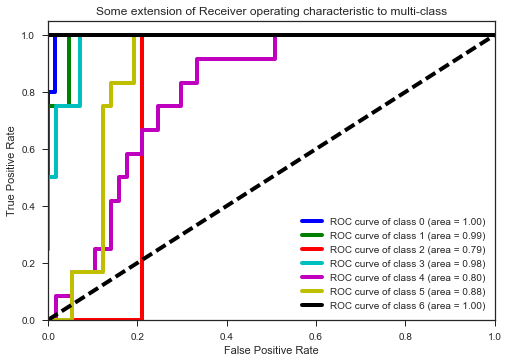

In [111]:
fpr = {}
tpr = {}
roc_auc = {}

y_score = OVS.predict_proba(df_with_all_features.iloc[:,0:-1])
for i in range(0,7):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(0,7)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(0,7):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 7


#colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
colors = cycle(['b','g','r','c','m','y','k'])
for i, color in zip(range(0,7), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=4,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

iii. Which method is better for multi-class classification in this problem?

By roc curve, it's obvious that the first method(L1-penalized multinomial regression model) has much better result.